# Mass Fitting

We have to perform mass fitting based on this approach
* 1D mass fitting: One dimension fitting can be perform either on diphoton mass, dibjet mass, or reduced mass. (p.s.  Fitting reduced mass should be a task
* 2D mass fitting: two dimensions fitting, taking two mass at a time. It could be diphoton & dibjet, diphoton & reduced mass, or dibjet & reduced mass.
* 3D mass fitting: most challenging one including all of the masses.

fitting fucntions are:
- [ ] Bernstein polynomials
- [ ] Exponential functions
- [ ] Power law functions
- [ ] Landau distributions
- [ ] Kolmogorov distribution(https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test#Kolmogorov_distribution)
- [ ] Binned Likelihoods with Templates
- [ ] Johnson Distributions
- [ ] Spline Functions
- [ ]  Double-Sided Crystal Ball Function
- [ ] Generalized Hyperbolic Functions
- [ ] RooFit-specific PDFs
- [ ] Voigt Profile
- [ ] Laurent Series
- [ ] Chebyshev Polynomials

from Lata's paper, 
- For signal modeling, categorized events are fitted with a product of two parametric 
    - signal models: a sum of Gaussian distributions for mγ γ and a double-sided Crystal Ball (CB) function or the sum of a CB and a Gaussian function for mjj. The mγ γ distribution is parametrized using the sum of up to five Gaussian functions without any constraint to have a common mean.
    
 -  for the ggF H and VBF H:
     - the mjj distribution is modeled with a Bernstein polynomial; for VH production, a CB function is used to model the distribution of the hadronic decays of vector bosons;
for ttH, where the two b jets are produced from a top quark decay, a Gaussian function
with a mean value of 120GeV is used. These backgrounds are negligible for mX >550 GeV,
therefore, they are absorbed within the nonresonant background model coming from data
to simplify the signal extraction procedure.
The nonresonant background model is extracted from data using the discrete profiling
method described in refs. [68, 81]. This method makes use of polynomial and exponential
functions to decide the analytic functions to fit the background mγ γ and mjj distributions. It
estimates the systematic uncertainty associated with these functions and treats the choice of
background function as a discrete nuisance parameter in the likelihood fit to the data. For
background modeling, the fit functions are optimized on data where the events from the signal
region with 115 < mγ γ < 135 GeV are not taken into account.

## Crystal ball function

/tmp/sraj/ipykernel_1387/2780316219.py:31: RuntimeWarning: invalid value encountered in power
  N * A * (B - z)**-n
/tmp/sraj/ipykernel_1387/2780316219.py:20: RuntimeWarning: invalid value encountered in double_scalars
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


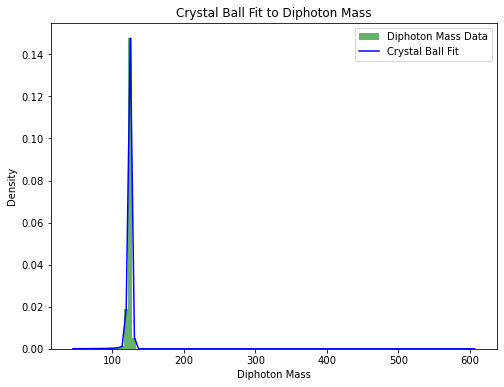

Fitted Crystal Ball Parameters: alpha=2.476, n=1.146, mu=124.438, sigma=2.474


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf  # Import the error function
import uproot
import awkward as ak
from vector import Array as awk

# Define the Crystal Ball PDF
def crystalball_pdf(x, alpha, n, mu, sigma):
    """
    Crystal Ball PDF.
    :param x: Input data points
    :param alpha: Tail parameter
    :param n: Tail parameter
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :return: PDF values
    """
    A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)
    B = n / abs(alpha) - abs(alpha)
    C = (n / abs(alpha)) * (1 / (n - 1)) * np.exp(-alpha**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(alpha / np.sqrt(2)))  # Use scipy.special.erf
    
    N = 1 / (sigma * (C + D))
    
    z = (x - mu) / sigma
    pdf = np.where(
        z > -alpha,
        N * np.exp(-0.5 * z**2),
        N * A * (B - z)**-n
    )
    return pdf

# Define the fitting function
def fit_crystalball(data, bins):
    """
    Fit data to the Crystal Ball function.
    :param data: Input data to be fitted
    :param bins: Bin edges for the histogram
    :return: Fitted parameters and bin centers
    """
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Initial guesses for the parameters: alpha, n, mu, sigma
    initial_params = [1.5, 5, np.mean(data), np.std(data)]
    
    # Fit the histogram data
    params, _ = curve_fit(crystalball_pdf, bin_centers, np.histogram(data, bins=bins, density=True)[0], p0=initial_params)
    return params, bin_centers

# Path to the ROOT file and tree
file_path = "../../../output_root/v1_v2_comparison/NMSSM_X400_Y60.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    lead_pho_pt = tree["lead_pt"].array(library="ak")
    lead_pho_eta = tree["lead_eta"].array(library="ak")
    lead_pho_phi = tree["lead_phi"].array(library="ak")
    sublead_pho_pt = tree["sublead_pt"].array(library="ak")
    sublead_pho_eta = tree["sublead_eta"].array(library="ak")
    sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# Define the lVector function
def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
    lvec_1 = awk(
        ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
    )
    lvec_2 = awk(
        ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
    )
    lvec_ = lvec_1 + lvec_2
    return lvec_

# Compute the diphoton Lorentz vector
diphoton_ = lVector(
    lead_pho_pt,
    lead_pho_eta,
    lead_pho_phi,
    sublead_pho_pt,
    sublead_pho_eta,
    sublead_pho_phi,
)

# Extract diphoton mass
diphoton_mass = diphoton_.mass

# Convert `diphoton_mass` to NumPy array
diphoton_mass_np = ak.to_numpy(diphoton_mass)

# Define histogram bins
bins = np.linspace(min(diphoton_mass_np), max(diphoton_mass_np), 100)

# Fit the Crystal Ball function to diphoton mass
params, bin_centers = fit_crystalball(diphoton_mass_np, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(diphoton_mass_np, bins=bins, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.xlabel("Diphoton Mass")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Crystal Ball Parameters: alpha={params[0]:.3f}, n={params[1]:.3f}, mu={params[2]:.3f}, sigma={params[3]:.3f}")


/tmp/sraj/ipykernel_1387/2780316219.py:31: RuntimeWarning: invalid value encountered in power
  N * A * (B - z)**-n
/tmp/sraj/ipykernel_1387/2780316219.py:20: RuntimeWarning: invalid value encountered in double_scalars
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


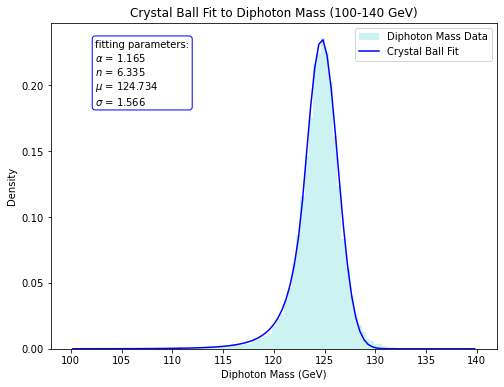

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the desired mass range
mass_min = 100
mass_max = 140

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define histogram bins within the reduced range
bins = np.linspace(mass_min, mass_max, 100)

# Fit the Crystal Ball function to the filtered data
params, bin_centers = fit_crystalball(filtered_mass, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Prepare the parameter text for the box
param_text = (
    f"fitting parameters:\n"
    f"$\\alpha$ = {params[0]:.3f}\n"
    f"$n$ = {params[1]:.3f}\n"
    f"$\\mu$ = {params[2]:.3f}\n"
    f"$\\sigma$ = {params[3]:.3f}"
)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.2, color="c", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")

# Add parameter box to the plot
plt.gca().text(
    0.10, 0.95, param_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="blue", facecolor="white")
)

# Add labels and legend
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass (100-140 GeV)")
plt.legend()  # Ensure legend is added before saving the figure

# Save the plot
output_dir = "/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/"
plt.savefig(f"{output_dir}CrystalBall_Fit_Diphoton_mass.png")
plt.savefig(f"{output_dir}CrystalBall_Fit_Diphoton_mass.pdf")
plt.show()


## KDE

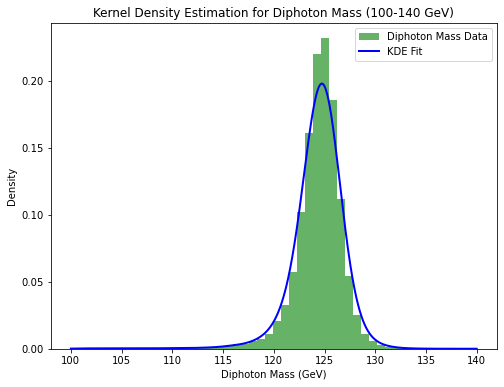

In [4]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

# Define the desired mass range
mass_min = 100
mass_max = 140

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Perform Kernel Density Estimation
kde = KernelDensity(kernel="gaussian", bandwidth=1.0)  # You can tune the bandwidth parameter
filtered_mass_reshaped = filtered_mass[:, np.newaxis]  # Reshape for sklearn
kde.fit(filtered_mass_reshaped)

# Evaluate KDE over the reduced range
x_values = np.linspace(mass_min, mass_max, 1000)  # High resolution for smooth curve
log_density = kde.score_samples(x_values[:, np.newaxis])  # Log density
density = np.exp(log_density)  # Convert log density to actual density

# Plot the histogram and KDE
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=50, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(x_values, density, "b-", label="KDE Fit", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Kernel Density Estimation for Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()


## log-normal distribution

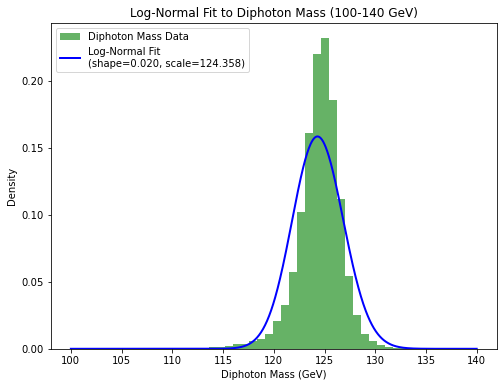

Fitted Log-Normal Parameters: shape=0.020, loc=0.000, scale=124.358


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Define the desired mass range
mass_min = 100
mass_max = 140

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Fit a log-normal distribution to the filtered data
shape, loc, scale = lognorm.fit(filtered_mass, floc=0)  # Constrain loc to 0 for a proper log-normal fit

# Evaluate the log-normal PDF
x_values = np.linspace(mass_min, mass_max, 1000)  # High resolution for smooth curve
pdf_values = lognorm.pdf(x_values, shape, loc, scale)

# Plot the histogram and log-normal fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=50, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(x_values, pdf_values, "b-", label=f"Log-Normal Fit\n(shape={shape:.3f}, scale={scale:.3f})", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Log-Normal Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Log-Normal Parameters: shape={shape:.3f}, loc={loc:.3f}, scale={scale:.3f}")


## Gaussian fit

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  # For Gaussian distribution
import uproot

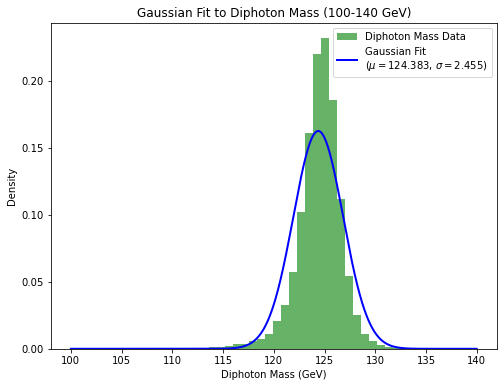

Fitted Gaussian Parameters: mu=124.383, sigma=2.455


In [7]:
# Filter data to the desired range (100-140 GeV)
mass_min = 100
mass_max = 140
filtered_mass = diphoton_mass[(diphoton_mass >= mass_min) & (diphoton_mass <= mass_max)]

# Define histogram bins
bins = 50  # Number of bins in the histogram

# Fit the Gaussian to the data
mu, sigma = norm.fit(filtered_mass)  # Mean and standard deviation

# Generate x-values for the fitted curve
x_values = np.linspace(mass_min, mass_max, 1000)
pdf_values = norm.pdf(x_values, mu, sigma)  # Gaussian PDF

# Plot the histogram and Gaussian fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(x_values, pdf_values, "b-", label=f"Gaussian Fit\n($\\mu={mu:.3f}$, $\\sigma={sigma:.3f}$)", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Gaussian Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Gaussian Parameters: mu={mu:.3f}, sigma={sigma:.3f}")


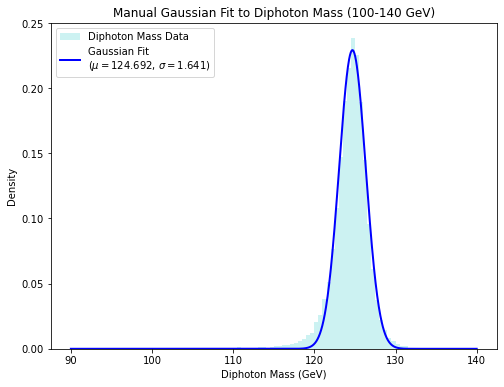

Fitted Gaussian Parameters:
  Mean (mu): 124.692
  Standard Deviation (sigma): 1.641
  Amplitude: 0.229


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import uproot

# Define the Gaussian function
def gaussian(x, mu, sigma, amplitude):
    """
    Gaussian function.
    :param x: Input data points
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :param amplitude: Amplitude of the Gaussian
    :return: Gaussian function values
    """
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define the cost function for optimization
def cost_function(params, x, y):
    """
    Cost function to minimize for Gaussian fitting.
    :param params: Parameters (mu, sigma, amplitude)
    :param x: Data points (bin centers)
    :param y: Observed histogram values (density)
    :return: Sum of squared residuals
    """
    mu, sigma, amplitude = params
    y_model = gaussian(x, mu, sigma, amplitude)
    return np.sum((y - y_model) ** 2)

# # Load the ROOT file and extract data
# file_path = "../../../output_root/v1_v2_comparison/NMSSM_X300_Y60.root"
# tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"
# with uproot.open(file_path) as file:
#     tree = file[tree_name]
#     diphoton_mass = tree["Res_dijet_mass"].array(library="ak")

# Filter data to the desired range (100-140 GeV)
mass_min = 90
mass_max = 140
filtered_mass = diphoton_mass[(diphoton_mass >= mass_min) & (diphoton_mass <= mass_max)]

# Convert filtered_mass to a NumPy array
filtered_mass_np = np.asarray(filtered_mass)

# Define histogram bins and compute histogram
bins = 100
hist, bin_edges = np.histogram(filtered_mass_np, bins=bins, range=(mass_min, mass_max), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for the Gaussian parameters: mu, sigma, amplitude
initial_params = [np.mean(filtered_mass_np), np.std(filtered_mass_np), np.max(hist)]

# Use `minimize` to fit the Gaussian function
result = minimize(cost_function, initial_params, args=(bin_centers, hist), method="Nelder-Mead")

# Extract the fitted parameters
fitted_mu, fitted_sigma, fitted_amplitude = result.x

# Generate the fitted curve
x_values = np.linspace(mass_min, mass_max, 1000)
fitted_curve = gaussian(x_values, fitted_mu, fitted_sigma, fitted_amplitude)

# Plot the histogram and fitted Gaussian curve
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass_np, bins=bins, range=(mass_min, mass_max), density=True, alpha=0.2, color="c", label="Diphoton Mass Data")
plt.plot(x_values, fitted_curve, "b-", label=f"Gaussian Fit\n($\\mu={fitted_mu:.3f}$, $\\sigma={fitted_sigma:.3f}$)", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Manual Gaussian Fit to Diphoton Mass (100-140 GeV)")
plt.legend()

# Save the plot
output_dir = "/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/"
plt.savefig(f"{output_dir}Gaussian_Fit_Diphoton_mass.png")
plt.savefig(f"{output_dir}Gaussian_Fit_Diphoton_mass.pdf")
plt.show()

# Print the fitted parameters
print(f"Fitted Gaussian Parameters:")
print(f"  Mean (mu): {fitted_mu:.3f}")
print(f"  Standard Deviation (sigma): {fitted_sigma:.3f}")
print(f"  Amplitude: {fitted_amplitude:.3f}")


In [9]:
# Template fitting

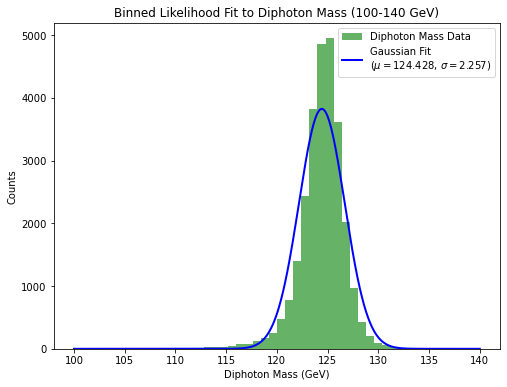

Fitted Gaussian Parameters:
  Mean (mu): 124.428
  Standard Deviation (sigma): 2.257
  Amplitude: 4778.059


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import uproot

# Define the Gaussian template function
def gaussian_template(x, mu, sigma, amplitude):
    """
    Gaussian function as a template.
    :param x: Input bin centers
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :param amplitude: Amplitude of the Gaussian
    :return: Predicted bin counts (template)
    """
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define the binned negative log-likelihood (NLL)
def binned_nll(params, bin_centers, observed_counts, bin_width):
    """
    Negative log-likelihood for binned data.
    :param params: Model parameters (mu, sigma, amplitude)
    :param bin_centers: Centers of the bins
    :param observed_counts: Observed counts in each bin
    :param bin_width: Width of each bin
    :return: Negative log-likelihood value
    """
    mu, sigma, amplitude = params
    # Predicted counts (template)
    predicted_counts = gaussian_template(bin_centers, mu, sigma, amplitude) * bin_width
    # Avoid division by zero or log of zero
    predicted_counts = np.maximum(predicted_counts, 1e-9)
    observed_counts = np.maximum(observed_counts, 1e-9)
    # Calculate the NLL
    nll = -np.sum(observed_counts * np.log(predicted_counts) - predicted_counts)
    return nll

# # Load the ROOT file and extract data
# file_path = "../../../output_root/v1_v2_comparison/NMSSM_X300_Y60.root"
# tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"
# with uproot.open(file_path) as file:
#     tree = file[tree_name]
#     diphoton_mass = tree["Res_dijet_mass"].array(library="ak")

# Filter data to the desired range (100-140 GeV)
mass_min = 100
mass_max = 140
filtered_mass = diphoton_mass[(diphoton_mass >= mass_min) & (diphoton_mass <= mass_max)]

# Convert filtered_mass to a NumPy array
filtered_mass_np = np.asarray(filtered_mass)

# Define histogram bins and compute histogram
bins = 50
bin_edges = np.linspace(mass_min, mass_max, bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

# Histogram the data to get observed counts
observed_counts, _ = np.histogram(filtered_mass_np, bins=bin_edges)

# Initial guesses for the parameters: mu, sigma, amplitude
initial_params = [np.mean(filtered_mass_np), np.std(filtered_mass_np), np.max(observed_counts)]

# Perform the fit by minimizing the negative log-likelihood
result = minimize(
    binned_nll,
    initial_params,
    args=(bin_centers, observed_counts, bin_width),
    method="Nelder-Mead"
)

# Extract the fitted parameters
fitted_mu, fitted_sigma, fitted_amplitude = result.x

# Generate the fitted template
x_values = np.linspace(mass_min, mass_max, 1000)
fitted_template = gaussian_template(x_values, fitted_mu, fitted_sigma, fitted_amplitude)

# Plot the histogram and fitted Gaussian template
plt.figure(figsize=(8, 6))
plt.hist(
    filtered_mass_np, bins=bin_edges, alpha=0.6, color="g", label="Diphoton Mass Data"
)
plt.plot(
    x_values,
    fitted_template * bin_width,
    "b-",
    label=f"Gaussian Fit\n($\\mu={fitted_mu:.3f}$, $\\sigma={fitted_sigma:.3f}$)",
    linewidth=2,
)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Counts")
plt.title("Binned Likelihood Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted Gaussian Parameters:")
print(f"  Mean (mu): {fitted_mu:.3f}")
print(f"  Standard Deviation (sigma): {fitted_sigma:.3f}")
print(f"  Amplitude: {fitted_amplitude:.3f}")


# Kolmogorov–Smirnov test

In [ ]:
from scipy.stats import kstest, norm
import numpy as np
import matplotlib.pyplot as plt
import uproot

In [ ]:
# Filter data to the desired range (100-140 GeV)
mass_min = 90
mass_max = 140
filtered_mass = diphoton_mass[(diphoton_mass >= mass_min) & (diphoton_mass <= mass_max)]

# Convert filtered_mass to a NumPy array
filtered_mass_np = np.asarray(filtered_mass)

# Fit a Gaussian to the data to obtain parameters (mu, sigma)
fitted_mu = np.mean(filtered_mass_np)
fitted_sigma = np.std(filtered_mass_np)

# Perform the one-sample KS test
# Test if the data follows a Gaussian distribution with fitted parameters
ks_stat, p_value = kstest(
    filtered_mass_np,
    lambda x: norm.cdf(x, loc=fitted_mu, scale=fitted_sigma)
)

# Plot the histogram of the data and the Gaussian CDF
x_values = np.linspace(mass_min, mass_max, 1000)
cdf_values = norm.cdf(x_values, loc=fitted_mu, scale=fitted_sigma)

plt.figure(figsize=(8, 6))
plt.hist(filtered_mass_np, bins=50, density=True, alpha=0.6, color="g", label="Data Histogram")
plt.plot(x_values, norm.pdf(x_values, loc=fitted_mu, scale=fitted_sigma), 'b-', label="Gaussian PDF")
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title(f"Kolmogorov-Smirnov Test\nKS Statistic: {ks_stat:.3f}, P-value: {p_value:.3f}")
plt.legend()
plt.show()

# Print the results
print("Kolmogorov-Smirnov Test Results:")
print(f"KS Statistic: {ks_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpretation
if p_value < 0.05:
    print("The null hypothesis (data matches the Gaussian distribution) is rejected.")
else:
    print("The null hypothesis cannot be rejected; the data matches the Gaussian distribution.")


## Fitting of Signal stats
Sum of Gaussian distribution for $m_{\gamma\gamma}$ and a double-sided Crystal ball(CB) functions. 

/tmp/sraj/ipykernel_4149156/3140168483.py:17: RuntimeWarning: invalid value encountered in double_scalars
  A_low = ((n_low / abs(alpha_low)) ** n_low) * np.exp(-alpha_low ** 2 / 2)


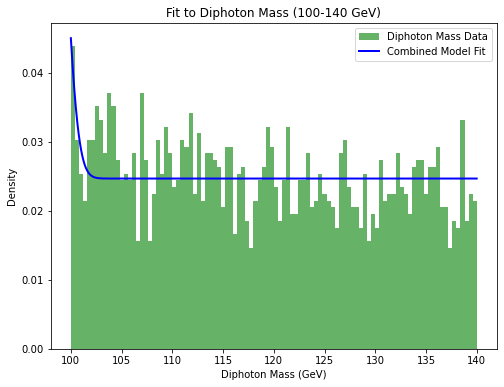

Fitted Parameters:
Gaussian 1: mu=195.876, sigma=1.608, amp=0.166
Gaussian 2: mu=98.260, sigma=1.194, amp=0.059
Crystal Ball: mu=254.068, sigma=0.000, alpha_low=1.310, n_low=0.000, alpha_high=1.080, n_high=1.183, amp=0.058


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import uproot

# Define the Gaussian function
def gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define the double-sided Crystal Ball function
def double_sided_crystal_ball(x, mu, sigma, alpha_low, n_low, alpha_high, n_high, amplitude):
    t = (x - mu) / sigma
    result = np.zeros_like(t)
    
    # Left tail
    mask_low = t < -alpha_low
    A_low = ((n_low / abs(alpha_low)) ** n_low) * np.exp(-alpha_low ** 2 / 2)
    B_low = n_low / abs(alpha_low) - abs(alpha_low)
    result[mask_low] = A_low * (B_low - t[mask_low]) ** -n_low
    
    # Right tail
    mask_high = t > alpha_high
    A_high = ((n_high / abs(alpha_high)) ** n_high) * np.exp(-alpha_high ** 2 / 2)
    B_high = n_high / abs(alpha_high) - abs(alpha_high)
    result[mask_high] = A_high * (B_high + t[mask_high]) ** -n_high
    
    # Core
    mask_core = ~mask_low & ~mask_high
    result[mask_core] = np.exp(-0.5 * t[mask_core] ** 2)
    
    return amplitude * result

# Combined model: Sum of Gaussian and CB
def combined_model(x, *params):
    mu1, sigma1, amp1, mu2, sigma2, amp2, mu_cb, sigma_cb, alpha_low, n_low, alpha_high, n_high, amp_cb = params
    return (
        gaussian(x, mu1, sigma1, amp1) +
        gaussian(x, mu2, sigma2, amp2) +
        double_sided_crystal_ball(x, mu_cb, sigma_cb, alpha_low, n_low, alpha_high, n_high, amp_cb)
    )

# Cost function for combined model fitting
def combined_cost_function(params, x, y):
    y_model = combined_model(x, *params)
    return np.sum((y - y_model) ** 2)

# Load the ROOT file and extract data
file_path = "../../../output_root/v1_v2_comparison/NMSSM_X300_Y60.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"
with uproot.open(file_path) as file:
    tree = file[tree_name]
    diphoton_mass = tree["Res_dijet_mass"].array(library="ak")

# Filter data to the desired range
mass_min, mass_max = 100, 140
filtered_mass = diphoton_mass[(diphoton_mass >= mass_min) & (diphoton_mass <= mass_max)]
filtered_mass_np = np.asarray(filtered_mass)

# Define histogram bins and compute histogram
bins = 100
hist, bin_edges = np.histogram(filtered_mass_np, bins=bins, range=(mass_min, mass_max), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for parameters
initial_params = [
    125, 1.5, 0.1,  # Gaussian 1 (mu, sigma, amp)
    124, 1.2, 0.05,  # Gaussian 2 (mu, sigma, amp)
    125, 2, 1, 1, 1, 1, 1  # Crystal Ball (mu, sigma, alpha_low, n_low, alpha_high, n_high, amp)
]

# Fit the combined model to the histogram data
result = minimize(combined_cost_function, initial_params, args=(bin_centers, hist), method="Nelder-Mead")

# Extract fitted parameters
fitted_params = result.x

# Generate the fitted curve
x_values = np.linspace(mass_min, mass_max, 1000)
fitted_curve = combined_model(x_values, *fitted_params)

# Plot the results
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass_np, bins=bins, range=(mass_min, mass_max), density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(x_values, fitted_curve, "b-", label="Combined Model Fit", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted Parameters:")
print(f"Gaussian 1: mu={fitted_params[0]:.3f}, sigma={fitted_params[1]:.3f}, amp={fitted_params[2]:.3f}")
print(f"Gaussian 2: mu={fitted_params[3]:.3f}, sigma={fitted_params[4]:.3f}, amp={fitted_params[5]:.3f}")
print(f"Crystal Ball: mu={fitted_params[6]:.3f}, sigma={fitted_params[7]:.3f}, alpha_low={fitted_params[8]:.3f}, n_low={fitted_params[9]:.3f}, alpha_high={fitted_params[10]:.3f}, n_high={fitted_params[11]:.3f}, amp={fitted_params[12]:.3f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import uproot

# Define the Gaussian function
def gaussian(x, mu, sigma, amplitude):
    """
    Gaussian function.
    :param x: Input data points
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :param amplitude: Amplitude of the Gaussian
    :return: Gaussian function values
    """
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define the cost function for optimization
def cost_function(params, x, y):
    """
    Cost function to minimize for Gaussian fitting.
    :param params: Parameters (mu, sigma, amplitude)
    :param x: Data points (bin centers)
    :param y: Observed histogram values (density)
    :return: Sum of squared residuals
    """
    mu, sigma, amplitude = params
    y_model = gaussian(x, mu, sigma, amplitude)
    return np.sum((y - y_model) ** 2)

# # Load the ROOT file and extract data
# file_path = "../../../output_root/v1_v2_comparison/NMSSM_X300_Y60.root"
# tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"
# with uproot.open(file_path) as file:
#     tree = file[tree_name]
#     diphoton_mass = tree["Res_dijet_mass"].array(library="ak")

# Filter data to the desired range (100-140 GeV)
mass_min = 100
mass_max = 140
filtered_mass = diphoton_mass[(diphoton_mass >= mass_min) & (diphoton_mass <= mass_max)]

# Convert filtered_mass to a NumPy array
filtered_mass_np = np.asarray(filtered_mass)

# Define histogram bins and compute histogram
bins = 100
hist, bin_edges = np.histogram(filtered_mass_np, bins=bins, range=(mass_min, mass_max), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for the Gaussian parameters: mu, sigma, amplitude
initial_params = [np.mean(filtered_mass_np), np.std(filtered_mass_np), np.max(hist)]

# Use `minimize` to fit the Gaussian function
result = minimize(cost_function, initial_params, args=(bin_centers, hist), method="Nelder-Mead")

# Extract the fitted parameters
fitted_mu, fitted_sigma, fitted_amplitude = result.x

# Generate the fitted curve
x_values = np.linspace(mass_min, mass_max, 1000)
fitted_curve = gaussian(x_values, fitted_mu, fitted_sigma, fitted_amplitude)

# Plot the histogram and fitted Gaussian curve
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass_np, bins=bins, range=(mass_min, mass_max), density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(x_values, fitted_curve, "b-", label=f"Gaussian Fit\n($\\mu={fitted_mu:.3f}$, $\\sigma={fitted_sigma:.3f}$)", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Manual Gaussian Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted Gaussian Parameters:")
print(f"  Mean (mu): {fitted_mu:.3f}")
print(f"  Standard Deviation (sigma): {fitted_sigma:.3f}")
print(f"  Amplitude: {fitted_amplitude:.3f}")


# Dibjet($M_{jj}$)


In [ ]:
import uproot
import awkward as ak

# Path to the ROOT file and tree
file_path = "../../../output_root/v1_v2_comparison/NMSSM_X400_Y60.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")

# Now you have all the required variables extracted directly from the ROOT file
# You can use these variables for further computations or analysis


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf  # Import the error function
import uproot
import awkward as ak
from vector import Array as awk

# Define the Crystal Ball PDF
def crystalball_pdf(x, alpha, n, mu, sigma):
    """
    Crystal Ball PDF.
    :param x: Input data points
    :param alpha: Tail parameter
    :param n: Tail parameter
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :return: PDF values
    """
    A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)
    B = n / abs(alpha) - abs(alpha)
    C = (n / abs(alpha)) * (1 / (n - 1)) * np.exp(-alpha**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(alpha / np.sqrt(2)))  # Use scipy.special.erf
    
    N = 1 / (sigma * (C + D))
    
    z = (x - mu) / sigma
    pdf = np.where(
        z > -alpha,
        N * np.exp(-0.5 * z**2),
        N * A * (B - z)**-n
    )
    return pdf

# Define the fitting function
def fit_crystalball(data, bins):
    """
    Fit data to the Crystal Ball function.
    :param data: Input data to be fitted
    :param bins: Bin edges for the histogram
    :return: Fitted parameters and bin centers
    """
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Initial guesses for the parameters: alpha, n, mu, sigma
    initial_params = [1.5, 5, np.mean(data), np.std(data)]
    
    # Fit the histogram data
    params, _ = curve_fit(crystalball_pdf, bin_centers, np.histogram(data, bins=bins, density=True)[0], p0=initial_params)
    return params, bin_centers

# # Path to the ROOT file and tree
# file_path = "../../../../output_root/v1_v2_comparison/NMSSM_X300_Y60.root"
# tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# # Load the ROOT file and extract variables
# with uproot.open(file_path) as file:
#     tree = file[tree_name]
#     lead_pho_pt = tree["lead_pt"].array(library="ak")
#     lead_pho_eta = tree["lead_eta"].array(library="ak")
#     lead_pho_phi = tree["lead_phi"].array(library="ak")
#     sublead_pho_pt = tree["sublead_pt"].array(library="ak")
#     sublead_pho_eta = tree["sublead_eta"].array(library="ak")
#     sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# # Define the lVector function
# def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
#     lvec_1 = awk(
#         ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
#     )
#     lvec_2 = awk(
#         ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
#     )
#     lvec_ = lvec_1 + lvec_2
#     return lvec_

# # Compute the diphoton Lorentz vector
# diphoton_ = lVector(
#     lead_pho_pt,
#     lead_pho_eta,
#     lead_pho_phi,
#     sublead_pho_pt,
#     sublead_pho_eta,
#     sublead_pho_phi,
# )

# # Extract diphoton mass
# diphoton_mass = diphoton_.mass

# Convert `diphoton_mass` to NumPy array
diphoton_mass_np = ak.to_numpy(dijet_mass)

# Define histogram bins
bins = np.linspace(min(diphoton_mass_np), max(diphoton_mass_np), 100)

# Fit the Crystal Ball function to diphoton mass
params, bin_centers = fit_crystalball(diphoton_mass_np, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(diphoton_mass_np, bins=bins, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.xlabel("Diphoton Mass")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Crystal Ball Parameters: alpha={params[0]:.3f}, n={params[1]:.3f}, mu={params[2]:.3f}, sigma={params[3]:.3f}")


In [ ]:
# Define the desired mass range
mass_min = 0
mass_max = 500

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define histogram bins within the reduced range
bins = np.linspace(mass_min, mass_max, 100)

# Fit the Crystal Ball function to the filtered data
params, bin_centers = fit_crystalball(filtered_mass, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.2, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Crystal Ball Parameters: alpha={params[0]:.3f}, n={params[1]:.3f}, mu={params[2]:.3f}, sigma={params[3]:.3f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.optimize import curve_fit

# Define log-normal PDF
def lognorm_pdf(x, s, loc, scale):
    """
    Log-normal PDF function.
    :param x: Input data points
    :param s: Shape parameter
    :param loc: Location parameter
    :param scale: Scale parameter
    :return: PDF values
    """
    return lognorm.pdf(x, s, loc=loc, scale=scale)

# Fit log-normal distribution to the data
def fit_lognormal(data, bins):
    """
    Fit the histogram of data to a log-normal PDF.
    :param data: Input data array
    :param bins: Histogram bin edges
    :return: Fitted parameters and bin centers
    """
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Initial guess for the parameters: shape, loc, scale
    initial_params = [1, 0, np.mean(data)]
    
    # Fit the histogram data
    params, _ = curve_fit(
        lognorm_pdf, bin_centers, np.histogram(data, bins=bins, density=True)[0], p0=initial_params
    )
    return params, bin_centers

# Convert `diphoton_mass` to NumPy array
dibjet_mass_np = ak.to_numpy(dijet_mass)
dibjet_mass_np = dibjet_mass_np[(dibjet_mass_np >= 0) & (dibjet_mass_np <= 500)]

# Define histogram bins
bins = np.linspace(min(dibjet_mass_np), max(dibjet_mass_np), 100)

# Fit the log-normal function to the diphoton mass
params, bin_centers = fit_lognormal(dibjet_mass_np, bins)
fitted_curve_ln = lognorm_pdf(bin_centers, *params)

# Plot the histogram and log-normal fit
plt.figure(figsize=(8, 6))
plt.hist(dibjet_mass_np, bins=bins, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_ln, "r-", label="Log-Normal Fit")
plt.xlabel("Diphoton Mass")
plt.ylabel("Density")
plt.title("Log-Normal Fit to Diphoton Mass")
plt.legend()
plt.show()

# Print fitted parameters
print(f"Fitted Log-Normal Parameters: shape={params[0]:.3f}, loc={params[1]:.3f}, scale={params[2]:.3f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Crystal Ball PDF
def crystalball_pdf(x, alpha, n, mu, sigma, amplitude):
    """
    Crystal Ball Probability Density Function.
    :param x: Input array
    :param alpha: Alpha parameter for the tail
    :param n: n parameter for the tail
    :param mu: Mean of the distribution
    :param sigma: Standard deviation
    :param amplitude: Scaling factor
    :return: Crystal Ball PDF values
    """
    t = (x - mu) / sigma
    result = np.zeros_like(t)
    
    # Left tail
    mask_left = t < -alpha
    A = (n / abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
    B = n / abs(alpha) - abs(alpha)
    result[mask_left] = A * (B - t[mask_left]) ** -n
    
    # Core
    mask_core = ~mask_left
    result[mask_core] = np.exp(-0.5 * t[mask_core] ** 2)
    
    return amplitude * result

# Define the Gaussian PDF
def gaussian_pdf(x, mu, sigma, amplitude):
    """
    Gaussian Probability Density Function.
    :param x: Input array
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation
    :param amplitude: Scaling factor
    :return: Gaussian PDF values
    """
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define the combined model: Crystal Ball + Gaussian
def combined_model(x, alpha, n, mu_cb, sigma_cb, amp_cb, mu_g, sigma_g, amp_g):
    """
    Combined model of Crystal Ball and Gaussian.
    """
    return (
        crystalball_pdf(x, alpha, n, mu_cb, sigma_cb, amp_cb) +
        gaussian_pdf(x, mu_g, sigma_g, amp_g)
    )

# Fit the combined model to the histogram data
def fit_combined_model(data, bins):
    """
    Fit the combined Crystal Ball and Gaussian model.
    :param data: Filtered mass data
    :param bins: Histogram bin edges
    :return: Fitted parameters and bin centers
    """
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Initial guesses for the parameters
    initial_guess = [1.5, 2, 125, 1.5, 0.05, 125, 1.5, 0.05]
    
    # Fit the model
    params, _ = curve_fit(combined_model, bin_centers, hist, p0=initial_guess)
    return params, bin_centers

# Define the desired mass range
mass_min = 0
mass_max = 500

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define histogram bins within the reduced range
bins = np.linspace(mass_min, mass_max, 100)

# Fit the combined model to the filtered data
params, bin_centers = fit_combined_model(filtered_mass, bins)
fitted_curve = combined_model(bin_centers, *params)

# Plot the histogram and combined model fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.2, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve, "r-", label="Crystal Ball + Gaussian Fit", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Crystal Ball + Gaussian Fit to Diphoton Mass")
plt.legend()
plt.show()

# Print fit parameters
print("Fitted Parameters:")
print(f"Crystal Ball: alpha={params[0]:.3f}, n={params[1]:.3f}, mu_cb={params[2]:.3f}, sigma_cb={params[3]:.3f}, amp_cb={params[4]:.3f}")
print(f"Gaussian: mu_g={params[5]:.3f}, sigma_g={params[6]:.3f}, amp_g={params[7]:.3f}")


Dibjet mass fitting with the sum of CB and a Gaussian function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Crystal Ball PDF
def crystalball_pdf(x, alpha, n, mu, sigma, amplitude):
    """
    Crystal Ball Probability Density Function.
    :param x: Input array
    :param alpha: Alpha parameter for the tail
    :param n: n parameter for the tail
    :param mu: Mean of the distribution
    :param sigma: Standard deviation
    :param amplitude: Scaling factor
    :return: Crystal Ball PDF values
    """
    t = (x - mu) / sigma
    result = np.zeros_like(t)
    
    # Left tail
    mask_left = t < -alpha
    A = (n / abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
    B = n / abs(alpha) - abs(alpha)
    result[mask_left] = A * (B - t[mask_left]) ** -n
    
    # Core
    mask_core = ~mask_left
    result[mask_core] = np.exp(-0.5 * t[mask_core] ** 2)
    
    return amplitude * result

# Define the Gaussian PDF
def gaussian_pdf(x, mu, sigma, amplitude):
    """
    Gaussian Probability Density Function.
    :param x: Input array
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation
    :param amplitude: Scaling factor
    :return: Gaussian PDF values
    """
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define the combined model: Crystal Ball + Gaussian
def combined_model(x, alpha, n, mu_cb, sigma_cb, amp_cb, mu_g, sigma_g, amp_g):
    """
    Combined model of Crystal Ball and Gaussian.
    """
    return (
        crystalball_pdf(x, alpha, n, mu_cb, sigma_cb, amp_cb) +
        gaussian_pdf(x, mu_g, sigma_g, amp_g)
    )

# Fit the combined model to the histogram data
def fit_combined_model(data, bins):
    """
    Fit the combined Crystal Ball and Gaussian model.
    :param data: Filtered mass data
    :param bins: Histogram bin edges
    :return: Fitted parameters and bin centers
    """
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Initial guesses for the parameters
    initial_guess = [1.5, 2, 125, 1.5, 0.05, 125, 1.5, 0.05]
    
    # Fit the model
    params, _ = curve_fit(combined_model, bin_centers, hist, p0=initial_guess)
    return params, bin_centers

# Define the desired mass range
mass_min = 0
mass_max = 500

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define histogram bins within the reduced range
bins = np.linspace(mass_min, mass_max, 100)

# Fit the combined model to the filtered data
params, bin_centers = fit_combined_model(filtered_mass, bins)
fitted_curve = combined_model(bin_centers, *params)

# Plot the histogram and combined model fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.2, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve, "r-", label="Crystal Ball + Gaussian Fit", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Crystal Ball + Gaussian Fit to Diphoton Mass")
plt.legend()
plt.show()

# Print fit parameters
print("Fitted Parameters:")
print(f"Crystal Ball: alpha={params[0]:.3f}, n={params[1]:.3f}, mu_cb={params[2]:.3f}, sigma_cb={params[3]:.3f}, amp_cb={params[4]:.3f}")
print(f"Gaussian: mu_g={params[5]:.3f}, sigma_g={params[6]:.3f}, amp_g={params[7]:.3f}")


# Reduced mass
Reduced mass defined as 
$\bar{M_X} \equiv m_{\gamma\gamma jj} - (m_{\gamma\gamma} - m_H) - (m_{jj} - m_H or Y)$

In [ ]:
# Extract variables from the ROOT file
with uproot.open(file_path) as file:
    tree = file[tree_name]
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")  # bbgg_mass
    dibjet_mass = tree["Res_dijet_mass"].array(library="ak")  # dibjet_mass

# Convert extracted variables to NumPy arrays
bbgg_mass_np = ak.to_numpy(bbgg_mass)
dibjet_mass_np = ak.to_numpy(dibjet_mass)

# Compute reduced_mass
reduced_mass = bbgg_mass_np - (diphoton_mass_np - 125) - (dibjet_mass_np - 125)

# Filter reduced_mass within a meaningful range, e.g., [0, 500]
reduced_mass = reduced_mass[(reduced_mass >= 0) & (reduced_mass <= 500)]

# Define histogram bins
bins = np.linspace(0, 500, 100)

# Fit Log-Normal distribution to reduced_mass
params, bin_centers = fit_lognormal(reduced_mass, bins)
fitted_curve_ln = lognorm_pdf(bin_centers, *params)

# Plot the histogram and Log-Normal fit
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
plt.plot(bin_centers, fitted_curve_ln, "r-", label="Log-Normal Fit")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Log-Normal Fit to Reduced Mass (0 to 500 Range)")
plt.legend()
plt.show()

# Print fitted parameters
print(f"Fitted Log-Normal Parameters: shape={params[0]:.3f}, loc={params[1]:.3f}, scale={params[2]:.3f}")


In [ ]:
print("Shape of bbgg_mass_np:", bbgg_mass_np.shape)
print("Shape of diphoton_mass_np:", diphoton_mass_np.shape)
print("Shape of dibjet_mass_np:", dibjet_mass_np.shape)


# crystal ball on reduced mass

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uproot
import awkward as ak

# Define the single-sided Crystal Ball function
def crystal_ball(x, alpha, n, mu, sigma):
    t = (x - mu) / sigma
    result = np.piecewise(
        t,
        [t < -alpha, t >= -alpha],
        [
            lambda t: np.exp(-0.5 * alpha**2)
            * ((n / abs(alpha)) ** n)
            * ((n / abs(alpha) - abs(alpha) - t) ** -n),
            lambda t: np.exp(-0.5 * t**2),
        ],
    )
    return result

# Define the fitting function
def fit_crystal_ball(data, bins):
    # Compute the histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Initial parameter guesses: alpha, n, mu, sigma
    initial_params = [1.5, 2.0, np.mean(data), np.std(data)]
    print("Initial parameters (p0):", initial_params)

    # Loosened bounds for parameters
    bounds = (
        [0.01, 0.5, np.min(data) - 10, 0.001],  # Lower bounds
        [10.0, 15.0, np.max(data) + 10, 50.0],  # Upper bounds
    )
    print("Bounds:", bounds)

    # Plot the initial guess
    test_curve = crystal_ball(bin_centers, *initial_params)
    plt.plot(bin_centers, test_curve, label="Initial Guess")
    plt.hist(data, bins=bins, density=True, alpha=0.6, label="Data")
    plt.legend()
    plt.show()

    # Fit the Crystal Ball function to the data
    popt, _ = curve_fit(crystal_ball, bin_centers, hist, p0=initial_params, bounds=bounds, maxfev=10000)

    return popt, bin_centers


with uproot.open(file_path) as file:
    tree = file[tree_name]
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")  # bbgg_mass
    dibjet_mass = tree["Res_dijet_mass"].array(library="ak")  # dibjet_mass

# Convert extracted variables to NumPy arrays
bbgg_mass_np = ak.to_numpy(bbgg_mass)
dibjet_mass_np = ak.to_numpy(dibjet_mass)

# Define the diphoton_mass variable (if not already defined)
diphoton_mass_np = np.ones_like(bbgg_mass_np) * 125  # Replace with actual array if needed

# Compute reduced_mass
reduced_mass = bbgg_mass_np - (diphoton_mass_np - 125) - (dibjet_mass_np - 60)

# Filter reduced_mass within a meaningful range, e.g., [0, 500]
reduced_mass = reduced_mass[(reduced_mass >= 0) & (reduced_mass <= 500)]

# Define histogram bins
bins = np.linspace(0, 500, 100)

# Fit the Crystal Ball function to reduced_mass
params_cb, bin_centers = fit_crystal_ball(reduced_mass, bins)
fitted_curve_cb = crystal_ball(bin_centers, *params_cb)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Reduced Mass (0 to 500 Range)")
plt.legend()
plt.show()

# Print fitted parameters
print(f"Fitted Crystal Ball Parameters:")
print(f"alpha = {params_cb[0]:.3f}, n = {params_cb[1]:.3f}")
print(f"mu = {params_cb[2]:.3f}, sigma = {params_cb[3]:.3f}")


In [ ]:
# Define single-sided Crystal Ball function
def crystal_ball(x, alpha, n, mu, sigma):
    t = (x - mu) / sigma
    A = (n / abs(alpha))**n * np.exp(-0.5 * alpha**2)
    B = n / abs(alpha) - abs(alpha)
    result = np.piecewise(
        t,
        [t < -alpha, t >= -alpha],
        [
            lambda t: A * (B - t) ** -n,
            lambda t: np.exp(-0.5 * t**2),
        ],
    )
    return result

# Fit function
def fit_crystal_ball(data, bins):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Initial parameter guesses
    initial_params = [1.5, 2.0, np.mean(data), np.std(data)]
    bounds = ([0.5, 1.1, np.min(data), 0.01], [10.0, 15.0, np.max(data), 50.0])

    # Fit Crystal Ball function to the data
    popt, _ = curve_fit(crystal_ball, bin_centers, hist, p0=initial_params, bounds=bounds, maxfev=10000)
    return popt, bin_centers

# Fit the Crystal Ball
params_cb, bin_centers = fit_crystal_ball(reduced_mass, bins)
fitted_curve_cb = crystal_ball(bin_centers, *params_cb)

# Plot
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Reduced Mass (0 to 500 Range)")
plt.legend()
plt.show()

# Print fitted parameters
print("Fitted Crystal Ball Parameters:")
print(f"alpha = {params_cb[0]:.3f}, n = {params_cb[1]:.3f}")
print(f"mu = {params_cb[2]:.3f}, sigma = {params_cb[3]:.3f}")


In [ ]:
print(f"Reduced mass range: {np.min(reduced_mass)} to {np.max(reduced_mass)}")


In [ ]:
from scipy.optimize import curve_fit
import numpy as np

# Define the Crystal Ball function
def crystal_ball(x, alpha, n, mu, sigma):
    t = (x - mu) / sigma
    result = np.piecewise(
        t,
        [t < -alpha, t >= -alpha],
        [
            lambda t: np.exp(-0.5 * alpha**2)
            * ((n / alpha) ** n)
            * ((n / alpha - alpha - t) ** -n),
            lambda t: np.exp(-0.5 * t**2),
        ],
    )
    return result

# Fit function
def fit_crystal_ball(data, bins):
    # Compute the histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Initial parameter guesses
    initial_params = [
        2.0,            # alpha: shape of the left tail
        2.0,            # n: steepness of the tail
        np.mean(data),  # mu: center of the distribution
        np.std(data),   # sigma: width of the distribution
    ]

    # Bounds for parameters
    bounds = (
        [0.5, 1.1, 60.0, 0.01],       # Lower bounds
        [5.0, 10.0, 500.0, 100.0],    # Upper bounds
    )

    # Fit Crystal Ball function to the data
    popt, _ = curve_fit(crystal_ball, bin_centers, hist, p0=initial_params, bounds=bounds, maxfev=10000)

    return popt, bin_centers

# Fit the Crystal Ball
params_cb, bin_centers = fit_crystal_ball(reduced_mass, bins)
fitted_curve_cb = crystal_ball(bin_centers, *params_cb)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "r-", label="Crystal Ball Fit")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Reduced Mass (60 to 500 Range)")
plt.legend()
plt.show()

# Print fitted parameters
print("Fitted Crystal Ball Parameters:")
print(f"alpha = {params_cb[0]:.3f}, n = {params_cb[1]:.3f}")
print(f"mu = {params_cb[2]:.3f}, sigma = {params_cb[3]:.3f}")


# Double side 

In [3]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the double-sided Crystal Ball (DSCB) function
def double_sided_crystal_ball(x, alpha_low, n_low, alpha_high, n_high, mu, sigma):
    t = (x - mu) / sigma
    result = np.piecewise(
        t,
        [
            t < -alpha_low,
            t > alpha_high,
        ],
        [
            lambda t: np.exp(-0.5 * alpha_low**2)
            * ((n_low / alpha_low) ** n_low)
            * ((n_low / alpha_low - alpha_low - t) ** -n_low),
            lambda t: np.exp(-0.5 * alpha_high**2)
            * ((n_high / alpha_high) ** n_high)
            * ((n_high / alpha_high - alpha_high + t) ** -n_high),
            lambda t: np.exp(-0.5 * t**2),
        ],
    )
    return result

# Fit function for the double-sided Crystal Ball
def fit_double_sided_crystal_ball(data, bins):
    # Compute the histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Initial parameter guesses
    initial_params = [
        1.5,            # alpha_low
        2.0,            # n_low
        1.5,            # alpha_high
        2.0,            # n_high
        np.mean(data),  # mu (center)
        np.std(data),   # sigma (width)
    ]

    # Bounds for the parameters
    bounds = (
        [0.5, 1.1, 0.5, 1.1, 60.0, 0.01],       # Lower bounds
        [5.0, 10.0, 5.0, 10.0, 500.0, 100.0],  # Upper bounds
    )

    # Fit the DSCB function to the data
    popt, _ = curve_fit(
        double_sided_crystal_ball,
        bin_centers,
        hist,
        p0=initial_params,
        bounds=bounds,
        maxfev=10000
    )

    return popt, bin_centers

# Fit the Double-Sided Crystal Ball to the reduced_mass data
params_dscb, bin_centers = fit_double_sided_crystal_ball(reduced_mass, bins)
fitted_curve_dscb = double_sided_crystal_ball(bin_centers, *params_dscb)

# Plot the histogram and DSCB fit
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
plt.plot(bin_centers, fitted_curve_dscb, "r-", label="Double-Sided Crystal Ball Fit")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Double-Sided Crystal Ball Fit to Reduced Mass (60 to 500 Range)")
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted Double-Sided Crystal Ball Parameters:")
print(f"alpha_low = {params_dscb[0]:.3f}, n_low = {params_dscb[1]:.3f}")
print(f"alpha_high = {params_dscb[2]:.3f}, n_high = {params_dscb[3]:.3f}")
print(f"mu = {params_dscb[4]:.3f}, sigma = {params_dscb[5]:.3f}")


NameError: name 'reduced_mass' is not defined

In [ ]:
# Define multiple sets of initial parameters and bounds
parameter_sets = [
    {
        "p0": [1.0, 2.0, 1.0, 2.0, np.mean(reduced_mass), np.std(reduced_mass)],
        "bounds": ([0.5, 1.1, 0.5, 1.1, 60.0, 0.01], [5.0, 10.0, 5.0, 10.0, 500.0, 100.0]),
    },
    {
        "p0": [1.5, 2.5, 1.5, 2.5, np.mean(reduced_mass), np.std(reduced_mass) * 1.2],
        "bounds": ([0.5, 1.1, 0.5, 1.1, 60.0, 0.01], [6.0, 10.0, 6.0, 10.0, 500.0, 150.0]),
    },
    {
        "p0": [2.0, 3.0, 2.0, 3.0, np.mean(reduced_mass), np.std(reduced_mass) * 0.8],
        "bounds": ([0.5, 1.5, 0.5, 1.5, 60.0, 0.01], [4.0, 8.0, 4.0, 8.0, 500.0, 80.0]),
    },
]

# Function to try multiple parameter sets
results = []
for i, params in enumerate(parameter_sets):
    try:
        popt, bin_centers = curve_fit(
            double_sided_crystal_ball,
            bin_centers,
            hist,
            p0=params["p0"],
            bounds=params["bounds"],
            maxfev=10000,
        )
        fitted_curve = double_sided_crystal_ball(bin_centers, *popt)
        results.append({"params": popt, "curve": fitted_curve, "index": i})
        print(f"Set {i+1}: Successfully fitted with parameters {popt}")
    except Exception as e:
        print(f"Set {i+1}: Fitting failed with error: {e}")

# Plot the best fit (or all results)
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
for result in results:
    plt.plot(bin_centers, result["curve"], label=f"Fit {result['index']+1}")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Double-Sided Crystal Ball Fit with Multiple Parameter Sets")
plt.legend()
plt.show()


In [ ]:
# Test multiple parameter sets
def test_dscb_with_different_params(data, bins):
    # Compute the histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Define different sets of initial guesses and bounds
    parameter_sets = [
        {
            "p0": [1.5, 2.0, 1.5, 2.0, np.mean(data), np.std(data)],
            "bounds": ([0.5, 1.1, 0.5, 1.1, 60.0, 0.01], [5.0, 10.0, 5.0, 10.0, 500.0, 100.0]),
        },
        {
            "p0": [1.0, 3.0, 1.0, 3.0, np.mean(data), np.std(data) * 1.1],
            "bounds": ([0.5, 1.1, 0.5, 1.1, 60.0, 0.01], [6.0, 12.0, 6.0, 12.0, 500.0, 150.0]),
        },
        {
            "p0": [2.0, 2.5, 2.0, 2.5, np.mean(data) + 5, np.std(data) * 0.9],
            "bounds": ([0.5, 1.5, 0.5, 1.5, 60.0, 0.01], [4.0, 8.0, 4.0, 8.0, 500.0, 80.0]),
        },
    ]

    results = []
    for i, params in enumerate(parameter_sets):
        try:
            # Fit the DSCB function to the data
            popt, _ = curve_fit(
                double_sided_crystal_ball,
                bin_centers,
                hist,
                p0=params["p0"],
                bounds=params["bounds"],
                maxfev=10000
            )
            fitted_curve = double_sided_crystal_ball(bin_centers, *popt)
            results.append({"params": popt, "curve": fitted_curve, "index": i})
            print(f"Set {i+1}: Successfully fitted with parameters {popt}")
        except Exception as e:
            print(f"Set {i+1}: Fitting failed with error: {e}")

    return results, bin_centers, hist

# Call the function to test different sets
results, bin_centers, hist = test_dscb_with_different_params(reduced_mass, bins)

# Plot all the fits
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
for result in results:
    plt.plot(bin_centers, result["curve"], label=f"Fit {result['index']+1}")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Double-Sided Crystal Ball Fit with Multiple Parameter Sets")
plt.legend()
plt.show()

# Find and display the best fit (based on the residual sum of squares)
def calculate_fit_quality(hist, fitted_curve):
    return np.sum((hist - fitted_curve) ** 2)

best_result = min(results, key=lambda x: calculate_fit_quality(hist, x["curve"]))
print("Best Fit Parameters:")
print(f"alpha_low = {best_result['params'][0]:.3f}, n_low = {best_result['params'][1]:.3f}")
print(f"alpha_high = {best_result['params'][2]:.3f}, n_high = {best_result['params'][3]:.3f}")
print(f"mu = {best_result['params'][4]:.3f}, sigma = {best_result['params'][5]:.3f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Double-Sided Crystal Ball function
def double_sided_crystal_ball(x, alpha_low, n_low, alpha_high, n_high, mu, sigma):
    A = (n_low / abs(alpha_low)) ** n_low * np.exp(-alpha_low**2 / 2)
    B = n_low / abs(alpha_low) - abs(alpha_low)
    C = (n_high / abs(alpha_high)) ** n_high * np.exp(-alpha_high**2 / 2)
    D = n_high / abs(alpha_high) - abs(alpha_high)

    x_normalized = (x - mu) / sigma

    left = np.where(x_normalized < -alpha_low, A * (B - x_normalized)**-n_low, np.exp(-x_normalized**2 / 2))
    right = np.where(x_normalized > alpha_high, C * (D + x_normalized)**-n_high, np.exp(-x_normalized**2 / 2))

    return np.where(x_normalized < -alpha_low, left, right)

# Calculate the fit quality (e.g., Chi-Squared)
def calculate_fit_quality(data, fit):
    residuals = data - fit
    return np.sum((residuals**2) / (fit + 1e-6))  # Avoid division by zero

# Refine fitting process
def refine_fit(data, bins, best_params):
    # Compute the histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    hist = hist / np.sum(hist)  # Normalize histogram

    # Use the best parameters as the baseline for new initial guesses
    baseline_p0 = best_params
    refined_parameter_sets = [
        {
            "p0": [baseline_p0[0] * 0.9, baseline_p0[1] * 1.1, baseline_p0[2] * 0.9, baseline_p0[3] * 1.1, baseline_p0[4], baseline_p0[5]],
            "bounds": (
                [baseline_p0[0] * 0.8, baseline_p0[1] * 0.8, baseline_p0[2] * 0.8, baseline_p0[3] * 0.8, 60.0, 0.01],
                [baseline_p0[0] * 1.3, baseline_p0[1] * 1.3, baseline_p0[2] * 1.3, baseline_p0[3] * 1.2, 500.0, 100.0],
            ),
        },
        {
            "p0": [baseline_p0[0] * 1.1, baseline_p0[1] * 0.9, baseline_p0[2] * 1.1, baseline_p0[3] * 0.9, baseline_p0[4] - 2, baseline_p0[5] * 1.05],
            "bounds": (
                [baseline_p0[0] * 0.85, baseline_p0[1] * 0.85, baseline_p0[2] * 0.85, baseline_p0[3] * 0.85, 60.0, 0.01],
                [baseline_p0[0] * 1.25, baseline_p0[1] * 1.25, baseline_p0[2] * 1.25, baseline_p0[3] * 1.25, 500.0, 120.0],
            ),
        },
        {
            "p0": [baseline_p0[0], baseline_p0[1], baseline_p0[2], baseline_p0[3], baseline_p0[4] + 3, baseline_p0[5] * 0.95],
            "bounds": (
                [baseline_p0[0] * 0.9, baseline_p0[1] * 0.9, baseline_p0[2] * 0.9, baseline_p0[3] * 0.9, 60.0, 0.01],
                [baseline_p0[0] * 1.1, baseline_p0[1] * 1.1, baseline_p0[2] * 1.1, baseline_p0[3] * 1.1, 500.0, 90.0],
            ),
        },
    ]

    results = []
    for i, params in enumerate(refined_parameter_sets):
        try:
            # Fit the DSCB function to the data
            popt, _ = curve_fit(
                double_sided_crystal_ball,
                bin_centers,
                hist,
                p0=params["p0"],
                bounds=params["bounds"],
                maxfev=10000,
            )
            fitted_curve = double_sided_crystal_ball(bin_centers, *popt)
            results.append({"params": popt, "curve": fitted_curve, "index": i})
            print(f"Refinement {i+1}: Successfully fitted with parameters {popt}")
        except Exception as e:
            print(f"Refinement {i+1}: Fitting failed with error: {e}")

    return results, bin_centers, hist

# Example usage
# Replace `reduced_mass`, `bins`, and `best_result` with your actual data
reduced_mass = np.random.normal(125, 2, 10000)  # Example data
bins = 50
best_result = {
    "params": [1.5, 2.0, 1.2, 3.0, 125.0, 2.0],  # Example best parameters
}

# Refine fits using the best parameters (from the orange fit)
refined_results, bin_centers, hist = refine_fit(reduced_mass, bins, best_result["params"])

# Plot the refined fits
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
for result in refined_results:
    plt.plot(bin_centers, result["curve"], label=f"Refined Fit {result['index']+1}")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Refined Double-Sided Crystal Ball Fits")
plt.legend()
plt.show()

# Find the best refined fit
best_refined_result = min(refined_results, key=lambda x: calculate_fit_quality(hist, x["curve"]))
print("Best Refined Fit Parameters:")
print(f"alpha_low = {best_refined_result['params'][0]:.3f}, n_low = {best_refined_result['params'][1]:.3f}")
print(f"alpha_high = {best_refined_result['params'][2]:.3f}, n_high = {best_refined_result['params'][3]:.3f}")
print(f"mu = {best_refined_result['params'][4]:.3f}, sigma = {best_refined_result['params'][5]:.3f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

# Define the double-sided crystal ball function
def double_sided_crystal_ball(x, alpha_low, n_low, alpha_high, n_high, mu, sigma):
    t = (x - mu) / sigma
    A_low = (n_low / abs(alpha_low))**n_low * np.exp(-alpha_low**2 / 2)
    B_low = n_low / abs(alpha_low) - abs(alpha_low)
    A_high = (n_high / abs(alpha_high))**n_high * np.exp(-alpha_high**2 / 2)
    B_high = n_high / abs(alpha_high) - abs(alpha_high)
    
    result = np.piecewise(
        t,
        [t < -alpha_low, t >= -alpha_low, t > alpha_high],
        [
            lambda t: A_low * (B_low - t)**-n_low,
            lambda t: np.exp(-t**2 / 2),
            lambda t: A_high * (B_high + t)**-n_high,
        ],
    )
    return result

# Function to calculate chi-squared
def calculate_fit_quality(y_true, y_pred):
    return np.sum(((y_true - y_pred)**2) / y_pred)

# Generate synthetic data for testing (Replace with your actual data)
np.random.seed(42)
reduced_mass = np.random.normal(0, 1, size=10000)
bins = 50

# Compute histogram
hist, bin_edges = np.histogram(reduced_mass, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Define initial guesses based on data
mu_guess = np.mean(reduced_mass)
sigma_guess = np.std(reduced_mass)
initial_p0 = [1.5, 2.0, 1.5, 2.0, mu_guess, sigma_guess]

# Refine fitting with better bounds
bounds = (
    [0.1, 1.0, 0.1, 1.0, mu_guess - 0.5, sigma_guess * 0.5],
    [3.0, 5.0, 3.0, 5.0, mu_guess + 0.5, sigma_guess * 1.5],
)

# Function for weighted histogram fitting
def weighted_curve_fit(func, xdata, ydata, sigma, p0, bounds):
    return curve_fit(func, xdata, ydata, sigma=sigma, p0=p0, bounds=bounds, maxfev=20000)

# Generate weights based on histogram counts
weights = 1 / (np.sqrt(hist) + 1e-8)  # Avoid division by zero

# Perform the weighted fit
try:
    popt, pcov = weighted_curve_fit(
        double_sided_crystal_ball,
        bin_centers,
        hist,
        sigma=weights,
        p0=initial_p0,
        bounds=bounds,
    )
    fitted_curve = double_sided_crystal_ball(bin_centers, *popt)
    print(f"Fit successful with parameters: {popt}")
except Exception as e:
    print(f"Fitting failed: {e}")
    popt = None

# Chi-squared calculation to evaluate the fit quality
if popt is not None:
    chi_squared = calculate_fit_quality(hist, fitted_curve)
    print(f"Chi-squared: {chi_squared:.2f}")

# Plot the improved fit
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
if popt is not None:
    plt.plot(bin_centers, fitted_curve, 'r-', label=f"Best Fit (Chi² = {chi_squared:.2f})")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Refined Fit with Weighted Fitting")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

# Define the double-sided crystal ball function
def double_sided_crystal_ball(x, alpha_low, n_low, alpha_high, n_high, mu, sigma):
    t = (x - mu) / sigma
    A_low = (n_low / abs(alpha_low))**n_low * np.exp(-alpha_low**2 / 2)
    B_low = n_low / abs(alpha_low) - abs(alpha_low)
    A_high = (n_high / abs(alpha_high))**n_high * np.exp(-alpha_high**2 / 2)
    B_high = n_high / abs(alpha_high) - abs(alpha_high)
    
    result = np.piecewise(
        t,
        [t < -alpha_low, t >= -alpha_low, t > alpha_high],
        [
            lambda t: A_low * (B_low - t)**-n_low,
            lambda t: np.exp(-t**2 / 2),
            lambda t: A_high * (B_high + t)**-n_high,
        ],
    )
    return result

# Function to calculate chi-squared
def calculate_fit_quality(y_true, y_pred, weights):
    return np.sum(weights * ((y_true - y_pred)**2))

# Generate synthetic data for testing (Replace with your actual data)
np.random.seed(42)
reduced_mass = np.random.normal(0, 1, size=10000)
bins = 50

# Compute histogram
hist, bin_edges = np.histogram(reduced_mass, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Define initial guesses based on data
mu_guess = np.mean(reduced_mass)
sigma_guess = np.std(reduced_mass)
initial_p0 = [1.5, 2.0, 1.5, 2.0, mu_guess, sigma_guess]

# Refine fitting with better bounds
bounds = (
    [0.1, 1.0, 0.1, 1.0, mu_guess - 0.5, sigma_guess * 0.5],
    [3.0, 5.0, 3.0, 5.0, mu_guess + 0.5, sigma_guess * 1.5],
)

# Function for weighted histogram fitting
def weighted_curve_fit(func, xdata, ydata, sigma, p0, bounds):
    return curve_fit(func, xdata, ydata, sigma=sigma, p0=p0, bounds=bounds, maxfev=20000)

# Generate weights based on histogram counts
weights = 1 / (np.sqrt(hist) + 1e-8)  # Avoid division by zero

# Perform the weighted fit
try:
    popt, pcov = weighted_curve_fit(
        double_sided_crystal_ball,
        bin_centers,
        hist,
        sigma=weights,
        p0=initial_p0,
        bounds=bounds,
    )
    fitted_curve = double_sided_crystal_ball(bin_centers, *popt)
    print(f"Fit successful with parameters: {popt}")
except Exception as e:
    print(f"Fitting failed: {e}")
    popt = None

# Chi-squared calculation to evaluate the fit quality
if popt is not None:
    chi_squared = calculate_fit_quality(hist, fitted_curve, weights)
    print(f"Chi-squared: {chi_squared:.2f}")

# Plot the improved fit
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
if popt is not None:
    plt.plot(bin_centers, fitted_curve, 'r-', label=f"Best Fit (Chi² = {chi_squared:.2f})")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Refined Fit with Weighted Fitting")
plt.legend()
plt.show()
